# Objetivo

Queremos criar um Collection score, ou seja, um modelo de Cobrança para o produto financiamento de veículos. A variável target foi criada seguindo a lógica: <br>

MAU = cliente que não pagou nada da dívida <br>
INDETERMINADO = cliente que pagou até 50% da dívida <br>
BOM = cliente que pagou pelo menos 50% da dívida <br>

Os clientes indeterminados serão removidos da base de treino do modelo. Para a avaliação da base completa eles serão considerados clientes bons.

# Análise dos dados

A base de dados possui 300.000 casos, com taxa de maus de 35% e referentes aos meses de 03/2022 a 01/2023.
Tal taxa de maus é estável ao longo do período.

A base de dados precisou de alguns pequenos ajustes associados a casos nulos, nos quais tivemos uma imputação pela mediana para as variáveis numéricas e a criação de uma categoria própria para as variáveis categóricas. Em um primeiro momento usei também de escalonamento por MinMax, mas como o modelo final ficou a Árvore de Decisão removi o escalonamento porque se tornou desnecessário e porque atrapalhava a interpretabilidade dos nós.

# Modelagem

A base de dados foi divida da seguinte forma: <br>
Base de treino: Meses 03/22 a 09/22 <br>
Base de teste: Meses 10/22 a 01/23

Testamos os algoritmos Árvore de Decisão, LightGBM e XGBoost. <br>
Os 3 algoritmos trazem resultados de KS / AUCROC muito parecidos tanto na base de treino quanto na base de teste, e por conta disso seguimos com o modelo de Árvore de Decisão por seu alto grau de explicabilidade. <br>

Apesar de ter sido cogitada a possibilidade de múltiplos modelos, como o resultado final da Árvore de Decisão claramente já segmenta o público por suas faixas de atraso, decidi manter um modelo único de forma a evitar questões associadas ao monitoramento e gestão de mais de um modelo sem um ganho justificável. <br>

Os piores nós da árvore estão associados a dias de atraso mais altos (acima de 51 dias), e com as variáveis var_144 (maior que 3) e var_166 (menor que 99,95), que não temos informações sobre. <br>
Já os melhores nós da árvore estão associados a dias de atraso mais baixos (até 15 dias) e idade acima de 34 anos. <br>

Separando os nós em 8 grupos homogêneos, com resultados apresentados ao final do notebook chegamos à seguinte proposta de atuação: <br>

Os grupos GH1 e GH2 têm menor taxa de maus, e portanto suas ações deveriam ser mensagens de SMS, email ou lembretes. <br>
Os grupos GH7 e GH8 têm alta taxa de maus, e portanto suas ações deveriam incluir negativação e/ou envio para uma cobradora. <br>
Os grupos GH3 a GH6 são os que possuem taxa de maus intermediária e portanto que fariam mais sentido acionamentos mais caros tal como chamada, <br>
e talvez negativação, mas em faixas de atraso maiores. Além disso priorizar o GH3 ante o GH6 por exemplo em qualquer ação.

In [88]:
import pandas as pd
import numpy as np
import time
import re
from ydata_profiling import ProfileReport

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import optuna

from sklearn.tree import DecisionTreeClassifier, plot_tree
import lightgbm as lgbm
import xgboost as xgb

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)


In [89]:
df = pd.read_csv('./data/base_cobranca.gz', sep='\t', compression='gzip')
df.head()

C:\Users\rafae\AppData\Local\Temp\ipykernel_15632\3422833284.py:1: DtypeWarning: Columns (12,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/base_cobranca.gz', sep='\t', compression='gzip')


,id,documento,mes_pagamento,dias_atraso,segmento_veiculo,saldo_vencido,pagamento,divida_restante,per_pago,GENERO,...,VAR_306,VAR_307,VAR_308,VAR_309,VAR_310,VAR_311,VAR_312,VAR_313,VAR_314,VAR_315
0,0x117651,0x722945,202301,18,leves,1445.37,0.00,1445.37,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x80136d,0x7fa1e8,202301,28,motos,426.84,426.84,0.00,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x839c27,0x724e31,202301,30,leves,1381.98,1381.98,0.00,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x7675af,0x827ea9,202210,22,leves,1299.22,1299.22,0.00,1.0,M,...,PROXIMO,MUITO LONGE,MUITO LONGE,0.0,1.0,RURAL,CENTRO-OESTE,NaN,D,NaN
4,0x52fa00,0x2772b2,202210,17,motos,493.42,0.00,493.42,0.0,F,...,MEDIO,PROXIMO,PROXIMO,1.0,1.0,URBANO,NORDESTE,0.0,B,1.0


In [90]:
df.columns[:15]

Index(['id', 'documento', 'mes_pagamento', 'dias_atraso', 'segmento_veiculo',
       'saldo_vencido', 'pagamento', 'divida_restante', 'per_pago', 'GENERO',
       'IDADE', 'UF', 'VAR_0', 'VAR_1', 'VAR_2'],
      dtype='object')

# Análise das variáveis preditivas

In [1]:
# Anotações:

# O id e documento não possuem nulos, mas o id não é único por safra, só o documento, de forma que então usarei documento como chave
# Ainda sobre o ponto anterior, isso significa que não farei "arrasto", e tratarei cada documento como não tendo relação com os outros
# O mes_pagamento vai de 202203 a 202301, sem nulos. Foi solicitado que a base de teste (OOT) seja de 202209 a 202301
# Dias de atraso indo de 8 a 90 dias, então clientes da Cobrança curta
# Há três segmentos de veículos: leves, pesados e motos, sendo majoritariamente leves, e tendo pouquíssimos casos do pesados
# Há alguns poucos casos de saldo vencido zero, um pouco estranho
# Há casos de pagamento negativo, provavelmente porque o cliente pagou a mais no mês anterior. Mas mais que isso, temos 35,4% de casos sem pagamento algum
# Já em dívida restante temos 37% de casos zerados, mostrando que portanto temos as situações: pagamento total, pagamento parcial e não pagamento
# O percentual de pagamento provavelmente é a divisão do pagamento pelo saldo_vencido
# Generos masculino, feminino e "i", predominantemente masculino, e há casos nulos
# Idade variando de 19 a 93 anos, com pico por volta dos 38 anos, e há casos nulos
# Há uma UF com um volume muito maior que as outras, e há casos nulos

# Além disso temos 315 variáveis mascaradas, que variam de tipo e podem possuir casos nulos ou outliers

In [92]:
profile = ProfileReport(df[df.columns[:12]], minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [93]:
df.columns = df.columns.str.lower()

In [94]:
df.loc[df[['id', 'mes_pagamento']].duplicated(keep=False)].sort_values(['id', 'mes_pagamento'])

,id,documento,mes_pagamento,dias_atraso,segmento_veiculo,saldo_vencido,pagamento,divida_restante,per_pago,genero,...,var_306,var_307,var_308,var_309,var_310,var_311,var_312,var_313,var_314,var_315
219800,0x100574,0x2002b7,202205,72,leves,7639.53,0.00,7639.53,0.00000,F,...,MEDIO,LONGE,LONGE,0.0,1.0,URBANO,SUDESTE,0.0,F,1.0
220452,0x100574,0x1df195,202205,61,leves,5550.82,0.00,5550.82,0.00000,F,...,MEDIO,LONGE,LONGE,0.0,1.0,URBANO,SUDESTE,0.0,F,1.0
233806,0x112bc2,0x4c846d,202205,61,leves,3757.35,0.00,3757.35,0.00000,M,...,PROXIMO,PROXIMO,MEDIO,1.0,1.0,URBANO,NORDESTE,0.0,A,1.0
269334,0x112bc2,0xbf732,202205,61,leves,1697.34,1697.34,0.00,1.00000,M,...,PROXIMO,PROXIMO,MEDIO,1.0,1.0,URBANO,NORDESTE,0.0,A,1.0
7439,0x116c8b,0x84db1,202301,23,leves,1370.07,0.00,1370.07,0.00000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152796,0xf8ad5,0x7fdbfd,202211,49,leves,658.04,0.00,658.04,0.00000,M,...,PROXIMO,PROXIMO,PROXIMO,0.0,1.0,URBANO,NORDESTE,0.0,F,1.0
226984,0xf8ad5,0x777f99,202211,72,leves,1315.98,0.00,1315.98,0.00000,M,...,PROXIMO,PROXIMO,PROXIMO,0.0,1.0,URBANO,NORDESTE,0.0,F,1.0
161658,0xfd0d0,0x86137b,202208,55,motos,1147.16,0.00,1147.16,0.00000,NaN,...,MEDIO,MUITO LONGE,MEDIO,1.0,1.0,URBANO,NORTE,NaN,F,NaN
257843,0xfd0d0,0x47cff3,202208,68,motos,1395.18,515.63,879.55,0.36958,NaN,...,MEDIO,MUITO LONGE,MEDIO,1.0,1.0,URBANO,NORTE,NaN,F,NaN


In [95]:
df.loc[df[['documento', 'mes_pagamento']].duplicated(keep=False)].sort_values(['documento', 'mes_pagamento'])

,id,documento,mes_pagamento,dias_atraso,segmento_veiculo,saldo_vencido,pagamento,divida_restante,per_pago,genero,...,var_306,var_307,var_308,var_309,var_310,var_311,var_312,var_313,var_314,var_315


In [96]:
# Brainstorming:

# Faz sentido usar a variável per_pago como variável resposta, de forma que 1 = BOM, 0 = MAU e qualquer valor entre eles é INDETERMINADO
# O dias de atraso é possivelmente a variável mais importante, e talvez seja necessário criarmos modelos distintos por faixa de atraso
# Já o segmento pode criar uma situação onde dois modelos seriam melhores, principalmente se as taxas de maus deles forem muito distintas

## Criação da variável resposta

In [97]:
# Se eu criar a variável resposta com a deinição de que mau é quem não pagou nada, bom é quem pagou tudo e indeterminado é quem pagou parcialmente, 
# terei um volume de indeterminados muito alto...

df['target_model'] = 999
df.loc[df['per_pago'] <= 0, 'target_model'] = 1
df.loc[df['per_pago'] == 1, 'target_model'] = 0
df.loc[(df['per_pago'] > 0) & (df['per_pago'] < 1), 'target_model'] = -1
 
df['target_model'].value_counts()/len(df)

target_model
 0    0.369573
 1    0.353523
-1    0.276903
Name: count, dtype: float64

In [98]:
df['per_pago'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])

count    300000.000000
mean          0.505766
std           0.432219
min          -0.289428
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.365998
50%           0.535156
60%           0.697927
70%           1.000000
80%           1.000000
90%           1.000000
95%           1.000000
99%           1.000000
max           1.000000
Name: per_pago, dtype: float64

In [99]:
# Seguirei assim, ou seja, considero que o cliente é bom se ele pagar pelo menos 50% da sua dívida, mas num cenário real eu conversaria com a área 
# de Negócios para criar essa definição.

df['target_model'] = 999
df.loc[df['per_pago'] <= 0, 'target_model'] = 1
df.loc[df['per_pago'] > 0.5, 'target_model'] = 0
df.loc[(df['per_pago'] > 0) & (df['per_pago'] <= 0.5), 'target_model'] = -1
 
df['target_model'].value_counts()/len(df)

target_model
 0    0.546970
 1    0.353523
-1    0.099507
Name: count, dtype: float64

In [100]:
# Os indeterminados serão removidos apenas da etapa de modelagem, fora dela usaremos a definição de que bons e indeterminados são bons, 
# ou seja, só é mau quem realmente não pagou nada.

df['target'] = 999
df.loc[df['per_pago'] <= 0, 'target'] = 1
df.loc[df['per_pago'] > 0, 'target'] = 0
 
df['target'].value_counts()/len(df)

target
0    0.646477
1    0.353523
Name: count, dtype: float64

In [101]:
# A taxa de maus é estável, mas um pouco mais alta no período OOT
df.groupby('mes_pagamento')['target'].agg(['count', 'mean'])

,count,mean
mes_pagamento,,
202203,26649,0.334459
202204,26965,0.375301
202205,28451,0.333872
202206,26612,0.345258
202207,26594,0.350793
202208,27436,0.320236
202209,26665,0.352672
202210,26169,0.364324
202211,27600,0.385543


## Possibilidade de múltiplos modelos

Analisando os dados temos as possibilidades de criar modelos segmentados por: faixa de atraso da dívida, segmento do veículo ou UF. <br>

Tanto segmento de veículo quanto UF não têm diferenças tão gritantes ao ponto de fazer sentido a criação de múltiplos modelos, com a ressalva que o veículo "Pesados" é um produto que apresenta sérias questões na Cobrança. <br>

Já a faixa de atraso impacta fortemente na taxa de maus, de forma que inicialmente faremos um modelo único e depois testaremos a segmentação por faixa de atraso.

In [102]:
df['fx_atraso'] = "Nulo"
df.loc[(df['dias_atraso'] > 7) & (df['dias_atraso'] <= 30), 'fx_atraso'] = "1. 8-30"
df.loc[(df['dias_atraso'] > 30) & (df['dias_atraso'] <= 60), 'fx_atraso'] = "2. 31-60"
df.loc[(df['dias_atraso'] > 60) & (df['dias_atraso'] <= 90), 'fx_atraso'] = "3. 61-90"

In [103]:
# Como era de se esperar há uma diferença muito grande nas taxas de maus da primeira pra terceira faixa.
df.groupby(['fx_atraso'])['target'].agg(['count', 'mean'])

,count,mean
fx_atraso,,
1. 8-30,100000,0.22251
2. 31-60,100000,0.34629
3. 61-90,100000,0.49177


In [104]:
# Já o segmento de veículos parece não ter grandes diferenças, a menos da situação muito ruim do "pesados". Como o volume é inexpressivo 
# no todo, os tratarei como outliers, mas o time de Negócios precisa repensar esse produto.
df.groupby(['segmento_veiculo'])['target'].agg(['count', 'mean'])

,count,mean
segmento_veiculo,,
leves,213667,0.350667
motos,86321,0.360526
pesados,12,0.833333


In [105]:
# De fato não precisamos de modelos separados por segmento
df.groupby(['fx_atraso', 'segmento_veiculo'])['target'].agg(['count', 'mean'])

count      mean
fx_atraso segmento_veiculo                 
1. 8-30   leves             70488  0.223627
          motos             29512  0.219843
2. 31-60  leves             72139  0.339830
          motos             27857  0.362997
          pesados               4  0.500000
3. 61-90  leves             71040  0.487725
          motos             28952  0.501554
          pesados               8  1.000000

In [106]:
df.loc[df['uf'].isnull(), 'uf'] = 'UF_NULA'

In [107]:
# Há UFs com taxas de maus piores que outras, mas não a ponto de considerarmos modelos separados.
df.groupby(['uf'])['target'].agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
uf,,
UF_19,2053,0.425231
UF_26,276,0.405797
UF_9,7355,0.398368
UF_6,4456,0.396544
UF_23,2548,0.392857
UF_2,2509,0.388202
UF_8,19465,0.386180
UF_10,912,0.382675
UF_NULA,38513,0.382105


## Preparação dos dados

In [108]:
df.loc[df['genero'].isnull(), 'genero'] = 'NULO'

In [109]:
df['fx_idade'] = pd.qcut(df['idade'], q=10)
df.groupby('fx_idade', observed=False)['target'].agg(['count', 'mean'])

,count,mean
fx_idade,,
"(19.369, 26.559]",26953,0.404074
"(26.559, 30.488]",26935,0.378504
"(30.488, 33.986]",26945,0.368269
"(33.986, 37.271]",26939,0.350458
"(37.271, 40.663]",26963,0.342914
"(40.663, 44.211]",26931,0.336267
"(44.211, 48.416]",26944,0.329684
"(48.416, 53.595]",26935,0.333692
"(53.595, 60.545]",26940,0.328768


In [110]:
# Colocarei -1 para que criemos uma categoria separada e porque as idades mais baixas têm a pior taxa de maus
df.loc[df['idade'].isnull(), 'idade'] = -1

In [111]:
df.drop(columns=['fx_idade'], inplace=True)

In [112]:
# Como eu não tenho nenhuma informação sobre as variáveis var_0 a var_315, farei uma preparação de dados genérica, usando a mediana para 
# preenchimento de nulos das variáveis numéricas, criando uma categoria "Nulo" para as variáveis categóricas e usando OneHotEncoder para 
# transformar as categóricas em numéricas de forma que possam ser trabalhadas nas árvores.

In [113]:
df.isna().sum().sort_values(ascending=False)/len(df)

var_19              1.000000
var_255             0.998810
var_0               0.998573
var_303             0.997277
var_39              0.997200
                      ...   
saldo_vencido       0.000000
segmento_veiculo    0.000000
dias_atraso         0.000000
mes_pagamento       0.000000
fx_atraso           0.000000
Length: 331, dtype: float64

In [114]:
# A variável var_19 foi removida por ser totalmente nula

df_train = df.loc[(df['mes_pagamento'] >= 202203) & (df['mes_pagamento'] < 202210)].copy()
df_test = df.loc[(df['mes_pagamento'] >= 202210)].copy()

x_train_final = df_train.drop(columns=['id', 'documento', 'mes_pagamento', 'target', 'target_model', 'pagamento', 'per_pago', 'divida_restante', 'var_19']).reset_index(drop=True)
x_test_final = df_test.drop(columns=['id', 'documento', 'mes_pagamento', 'target', 'target_model', 'pagamento', 'per_pago', 'divida_restante', 'var_19']).reset_index(drop=True)

y_train_final = df_train.reset_index(drop=True)['target']
y_test_final = df_test.reset_index(drop=True)['target']

x_train = df_train.loc[df_train['target_model'] != -1].drop(columns=['id', 'documento', 'mes_pagamento', 'target', 'target_model', 'pagamento', 'per_pago', 'divida_restante', 'var_19']).reset_index(drop=True)
x_test = df_test.loc[df_test['target_model'] != -1].drop(columns=['id', 'documento', 'mes_pagamento', 'target', 'target_model', 'pagamento', 'per_pago', 'divida_restante', 'var_19']).reset_index(drop=True)

y_train = df_train.loc[df_train['target_model'] != -1].reset_index(drop=True)['target_model']
y_test = df_test.loc[df_test['target_model'] != -1].reset_index(drop=True)['target_model']

In [ ]:
class PreparadorDeDados:
    def __init__(self, max_categorias=8):
        self.max_categorias = max_categorias
        self.imputer_num = None
        self.encoder = None
        self.scaler = None
        self.categorias_mais_comuns = {}

    def preparar_dados(self, df_train):
        # 1. Separar variáveis numéricas e categóricas
        variaveis_numericas = df_train.select_dtypes(include=['float64', 'int64']).columns
        variaveis_categoricas = df_train.select_dtypes(include=['object', 'category']).columns

        # 2. Tratamento de Valores Nulos
        # Preenchimento de nulos para variáveis numéricas (mediana) - apenas no treino
        self.imputer_num = SimpleImputer(strategy='median')
        df_train[variaveis_numericas] = self.imputer_num.fit_transform(df_train[variaveis_numericas])

        # Preenchimento de nulos para variáveis categóricas (transformar em 'NULO')
        df_train[variaveis_categoricas] = df_train[variaveis_categoricas].fillna('NULO')

        # 3. Agrupar categorias menos frequentes para variáveis com mais de 'max_categorias' categorias
        for col in variaveis_categoricas:
            num_categorias = df_train[col].nunique()
            if num_categorias > self.max_categorias:
                # Identificar as 'max_categorias' categorias mais comuns e armazenar para uso posterior
                categorias_comuns = df_train[col].value_counts().nlargest(self.max_categorias).index
                self.categorias_mais_comuns[col] = categorias_comuns
                # Substituir categorias menos frequentes por 'Outros'
                df_train[col] = df_train[col].apply(lambda x: x if x in categorias_comuns else 'Outros')
            else:
                self.categorias_mais_comuns[col] = df_train[col].unique()  # Para aplicar no teste

        # 4. Codificação One-Hot das Variáveis Categóricas
        self.encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        df_categoricas_encoded = pd.DataFrame(self.encoder.fit_transform(df_train[variaveis_categoricas]), columns=self.encoder.get_feature_names_out(variaveis_categoricas), index=df_train.index)
        
        # Concatenar as variáveis codificadas e remover as originais
        df_train = pd.concat([df_train.drop(columns=variaveis_categoricas), df_categoricas_encoded], axis=1)

        # 5. Escalonamento das variáveis numéricas (apenas no treino)
        self.scaler = MinMaxScaler()
        df_train[variaveis_numericas] = self.scaler.fit_transform(df_train[variaveis_numericas])

        return df_train

    def transformar_dados(self, df_test):
        # 1. Separar variáveis numéricas e categóricas
        variaveis_numericas = df_test.select_dtypes(include=['float64', 'int64']).columns
        variaveis_categoricas = df_test.select_dtypes(include=['object', 'category']).columns

        # 2. Tratamento de Valores Nulos
        # Aplicar o mesmo imputador de nulos nas variáveis numéricas
        df_test[variaveis_numericas] = self.imputer_num.transform(df_test[variaveis_numericas])

        # Preenchimento de nulos para variáveis categóricas
        df_test[variaveis_categoricas] = df_test[variaveis_categoricas].fillna('NULO')

        # 3. Agrupamento de categorias baseado no treino
        for col in variaveis_categoricas:
            if col in self.categorias_mais_comuns:
                categorias_comuns = self.categorias_mais_comuns[col]
                df_test[col] = df_test[col].apply(lambda x: x if x in categorias_comuns else 'Outros')

        # 4. Codificação One-Hot das Variáveis Categóricas (usar encoder ajustado no treino)
        df_categoricas_encoded = pd.DataFrame(self.encoder.transform(df_test[variaveis_categoricas]), columns=self.encoder.get_feature_names_out(variaveis_categoricas), index=df_test.index)
        
        # Concatenar as variáveis codificadas e remover as originais
        df_test = pd.concat([df_test.drop(columns=variaveis_categoricas), df_categoricas_encoded], axis=1)

        # 5. Escalonamento das variáveis numéricas (usar scaler ajustado no treino)
        df_test[variaveis_numericas] = self.scaler.transform(df_test[variaveis_numericas])

        return df_test


In [116]:
# Instanciar a classe de preparação de dados
preparador = PreparadorDeDados(max_categorias=8)

In [117]:
df_train_preparado = preparador.preparar_dados(x_train)
df_test_preparado = preparador.transformar_dados(x_test)

x_train_final = preparador.transformar_dados(x_train_final)
x_test_final = preparador.transformar_dados(x_test_final)

In [118]:
df_test_preparado

,dias_atraso,saldo_vencido,idade,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_314_A,var_314_B,var_314_C,var_314_D,var_314_E,var_314_F,var_314_NULO,fx_atraso_1. 8-30,fx_atraso_2. 31-60,fx_atraso_3. 61-90
0,18.0,1445.37,-1.000,0.0,0.280,0.282,0.203,0.182,0.833333,2.113915,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,28.0,426.84,-1.000,0.0,0.280,0.282,0.203,0.182,0.833333,2.113915,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,30.0,1381.98,-1.000,0.0,0.280,0.282,0.203,0.182,0.833333,2.113915,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,22.0,1299.22,55.140,0.0,0.203,0.282,0.203,0.182,0.750000,2.113915,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,17.0,493.42,46.405,0.0,0.223,0.282,0.203,0.182,0.916667,2.113915,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99962,88.0,3772.17,37.279,0.0,0.057,0.282,0.203,0.145,0.833333,2.113915,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
99963,75.0,1852.98,-1.000,0.0,0.280,0.282,0.203,0.182,0.833333,2.113915,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
99964,84.0,2134.02,41.740,0.0,0.308,0.282,0.203,0.182,1.000000,2.113915,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
99965,81.0,1902.48,-1.000,0.0,0.280,0.282,0.203,0.182,0.833333,2.113915,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Modelagem

### Modelo simples e basal

In [119]:
# Calcule o KS
def ks_metric(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    return ks

In [120]:
tree = DecisionTreeClassifier(
    criterion='gini', 
    min_samples_leaf=int(0.05 * len(df_train_preparado)),  # Garantir que cada nó tenha pelo menos 5% dos casos
    max_depth=None,
    random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(tree, df_train_preparado, y_train, cv=cv, scoring='roc_auc')

tree.fit(df_train_preparado, y_train)

y_train_pred_proba = tree.predict_proba(df_train_preparado)[:, 1]
y_test_pred_proba = tree.predict_proba(df_test_preparado)[:, 1]

auc_roc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_roc_test = roc_auc_score(y_test, y_test_pred_proba)

ks_train = ks_metric(y_train, y_train_pred_proba)
ks_test = ks_metric(y_test, y_test_pred_proba)

print(f'ROC AUC (Cross Validation): {roc_auc_scores.mean():.4f}')
print(f'AUC-ROC Train: {auc_roc_train:.4f}')
print(f'AUC-ROC Test: {auc_roc_test:.4f}')
print('')
print(f'KS Train: {ks_train:.4f}')
print(f'KS Test: {ks_test:.4f}')

ROC AUC (Cross Validation): 0.7124
AUC-ROC Train: 0.7148
AUC-ROC Test: 0.7206

KS Train: 0.3206
KS Test: 0.3397


### Feature selection usando LightGBM (método de Forward feature selection)

In [ ]:
# Definindo os parâmetros iniciais do modelo LightGBM
params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': 42,
    'min_child_samples': int(0.01 * len(df_train_preparado))
}

# Treinando o modelo inicial para obter a importância das variáveis
model = lgbm.LGBMClassifier(**params)
model.fit(df_train_preparado, y_train)

# Criando um DataFrame com as importâncias das variáveis e ordenando em ordem decrescente
feature_importances = pd.DataFrame({
    'feature': df_train_preparado.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Lista ordenada das variáveis com base na importância
ordered_features = feature_importances['feature'].tolist()

# Inicializando a lista para armazenar as variáveis selecionadas e o melhor AUC-ROC encontrado
selected_features = []
best_auc_roc = 0  # Inicialmente, o AUC_ROC é definido como zero para sempre haver uma melhoria inicial
start_time = time.time()  # Marcador do tempo inicial para monitoramento

# Loop para seleção de variáveis, adicionando uma por uma e avaliando o impacto no erro
for i, feature in enumerate(ordered_features, start=1):
    # Conjunto atual de features inclui as já selecionadas mais a nova feature a ser testada
    current_features = selected_features + [feature]
    
    # Treinando o modelo com o conjunto atual de variáveis
    model = lgbm.LGBMClassifier(**params)
    model.fit(df_train_preparado[current_features], y_train)
    
    # Prevendo no conjunto de teste e calculando o AUC-ROC
    y_train_pred = model.predict_proba(df_train_preparado[current_features])[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred)
    
    # Verificação se o AUC-ROC atual é melhor do que o melhor AUC-ROC encontrado até o momento
    if train_auc > best_auc_roc:
        # Atualizando o melhor AUC-ROC e adicionando a feature à lista de selecionadas
        best_auc_roc = train_auc
        selected_features.append(feature)
        status = "mantida"  # Marcação de status para a feature mantida
    else:
        status = "descartada"  # Marcação de status para a feature descartada
    
    # Calculando o tempo decorrido
    elapsed_time = (time.time() - start_time) / 60  # Tempo em minutos
    
    # Exibindo o status da feature atual, o AUC-ROC e o tempo decorrido
    print(f"Feature '{feature}' {status} (AUC-ROC: {train_auc:.4f}) | Tempo (min): {elapsed_time:.2f} | Iteração {i}/{len(ordered_features)}")

# Exibindo a lista final de variáveis selecionadas para a modelagem
print("\nLista de variáveis selecionadas para modelagem:")
print(selected_features)

In [122]:
selected_features = ['saldo_vencido',
 'dias_atraso',
 'var_144',
 'var_143',
 'var_168',
 'var_21',
 'var_165',
 'idade',
 'var_35',
 'var_22',
 'var_166',
 'var_158',
 'segmento_veiculo_leves',
 'var_159',
 'var_254',
 'var_253',
 'var_32',
 'var_33',
 'var_264',
 'var_186',
 'var_134',
 'var_192',
 'var_267',
 'var_148',
 'var_161',
 'var_157',
 'var_160',
 'var_271',
 'var_268',
 'uf_UF_0',
 'var_152',
 'var_12',
 'var_34',
 'var_194',
 'var_178',
 'var_218',
 'var_9',
 'var_222',
 'var_23',
 'var_300',
 'var_150',
 'var_173',
 'var_139',
 'var_187',
 'var_226',
 'var_272',
 'var_146',
 'var_230',
 'var_147',
 'var_277',
 'var_207',
 'var_278',
 'var_193',
 'var_306_MEDIO',
 'var_98_MEDIO',
 'var_47_S',
 'var_60_BAIXISSIMA',
 'var_90_ALTA',
 'var_130_MEDIO',
 'var_101_MEDIO',
 'var_127_PROXIMO',
 'var_131_LONGE',
 'var_51_N',
 'var_58_S',
 'var_3_ALTA',
 'var_100_MUITO LONGE',
 'var_73_MEDIA',
 'var_86_ALTA']

### Otimização de hiperparâmetros dos algortimos Decision Tree, LightGBM e XGBoost

In [123]:
# Filtrando as variáveis no conjunto de treino e teste com base na seleção final
df_train_preparado = df_train_preparado[selected_features]
df_test_preparado = df_test_preparado[selected_features]

In [124]:
# X_train_ot, X_test_ot, y_train_ot, y_test_ot = train_test_split(df_train_preparado, y_train, test_size=0.2, random_state=42)

In [125]:
# # Definir a função de otimização para o LightGBM
# def lightgbm_optimizer(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', int(0.01 * len(X_train_ot)), int(0.1 * len(X_train_ot))),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0, log=True),
#         'subsample': trial.suggest_float('subsample', 0.7, 1.0, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 7),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 200),
#         'random_state': 42
#     }
#     model = lgbm.LGBMClassifier(**params)
#     return cross_val_auc(model)

# # Definir a função de otimização para o Decision Tree
# def decision_tree_optimizer(trial):
#     params = {
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', int(0.01 * len(X_train_ot)), int(0.1 * len(X_train_ot))),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
#         'random_state': 42
#     }
#     model = DecisionTreeClassifier(**params)
#     return cross_val_auc(model)

# # Definir a função de otimização para o XGBoost
# def xgboost_optimizer(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 7),
#         'subsample': trial.suggest_float('subsample', 0.7, 1.0, log=True),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0, log=True),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
#         'eval_metric': ['auc'],
#         'random_state': 42
#     }
#     model = xgb.XGBClassifier(**params)
#     return cross_val_auc(model)

# # Função auxiliar para realizar validação cruzada e calcular AUC
# def cross_val_auc(model):
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     auc_roc_scores = []

#     for train_index, val_index in kf.split(X_train_ot, y_train_ot):
#         X_tr, X_val = X_train_ot.iloc[train_index], X_train_ot.iloc[val_index]
#         y_tr, y_val = y_train_ot.iloc[train_index], y_train_ot.iloc[val_index]

#         model.fit(X_tr, y_tr)
#         y_val_pred = model.predict_proba(X_val)[:, 1]
        
#         auc_roc = roc_auc_score(y_val, y_val_pred)
#         auc_roc_scores.append(auc_roc)

#     return np.mean(auc_roc_scores)


In [ ]:
# # Otimização para LightGBM
study_lightgbm = optuna.create_study(direction='maximize')
study_lightgbm.optimize(lightgbm_optimizer, n_trials=100)
best_params_lightgbm = study_lightgbm.best_params
print("Melhores parâmetros para o LightGBM:", best_params_lightgbm)

In [127]:
best_params_lightgbm = {'learning_rate': 0.041529940545962825, 'n_estimators': 320, 'min_child_samples': 1631, 'colsample_bytree': 0.7765053735198245, 'subsample': 0.8385127147154782, 'max_depth': 5, 'num_leaves': 28}

In [ ]:
# # Otimização para Decision Tree
study_decision_tree = optuna.create_study(direction='maximize')
study_decision_tree.optimize(decision_tree_optimizer, n_trials=100)
best_params_decision_tree = study_decision_tree.best_params
print("Melhores parâmetros para a Decision Tree:", best_params_decision_tree)

In [129]:
best_params_decision_tree = {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 9469, 'max_features': None}

In [ ]:
# # Otimização para XGBoost
study_xgboost = optuna.create_study(direction='maximize')
study_xgboost.optimize(xgboost_optimizer, n_trials=100)
best_params_xgboost = study_xgboost.best_params
print("Melhores parâmetros para o XGBoost:", best_params_xgboost)

In [132]:
best_params_xgboost = {'learning_rate': 0.009793878461572805, 'n_estimators': 799, 'max_depth': 7, 'subsample': 0.8318962680555252, 'colsample_bytree': 0.9308996817344601, 'gamma': 1.2974894105068533, 'reg_alpha': 0.27820785742810994, 'reg_lambda': 0.5700162467983982}

In [ ]:
del X_train_ot, X_test_ot, y_train_ot, y_test_ot

### Modelagem com hiperparâmetros ajustados

In [134]:
x_train_final = x_train_final[selected_features]
x_test_final = x_test_final[selected_features]

In [135]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Decision Tree': DecisionTreeClassifier(**best_params_decision_tree),
    'LightGBM': lgbm.LGBMClassifier(**best_params_lightgbm),
    'XGBoost': xgb.XGBClassifier(**best_params_xgboost)
}

results = {}
for name, model in models.items():
    auc_scores = []
    ks_scores = []
    for train_index, val_index in skf.split(x_train_final, y_train_final):
        X_tr, X_val = x_train_final.iloc[train_index], x_train_final.iloc[val_index]
        y_tr, y_val = y_train_final.iloc[train_index], y_train_final.iloc[val_index]
        
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        
        # AUC
        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)
        
        # KS
        ks = ks_metric(y_val, y_val_pred)
        ks_scores.append(ks)
    

    # Avaliar no conjunto de treino
    model.fit(x_train_final, y_train_final)
    y_train_final_pred = model.predict_proba(x_train_final)[:, 1]
    
    train_auc = roc_auc_score(y_train_final, y_train_final_pred)
    train_ks = ks_metric(y_train_final, y_train_final_pred)
    
    # Avaliar no conjunto de teste
    y_test_pred = model.predict_proba(x_test_final)[:, 1]
    
    test_auc = roc_auc_score(y_test_final, y_test_pred)
    test_ks = ks_metric(y_test_final, y_test_pred)
    
    results[name] = {
        'AUC CV': np.mean(auc_scores),
        'AUC Treino': train_auc,
        'AUC Teste': test_auc,
        'KS CV': np.mean(ks_scores),
        'KS Treino': train_ks,
        'KS Teste': test_ks
    }

final_results_df = pd.DataFrame(results)
final_results_df

,Decision Tree,LightGBM,XGBoost
AUC CV,0.645667,0.669133,0.671939
AUC Treino,0.648689,0.684288,0.731822
AUC Teste,0.655511,0.667736,0.670767
KS CV,0.213135,0.244986,0.249079
KS Treino,0.213224,0.265162,0.330182
KS Teste,0.228293,0.237440,0.243185


## Árvore de decisão
Como a performance da Decision Tree foi semelhante a dos algoritmos mais complexos, usaremos a Decision Tree por seu baixo nível de complexidade

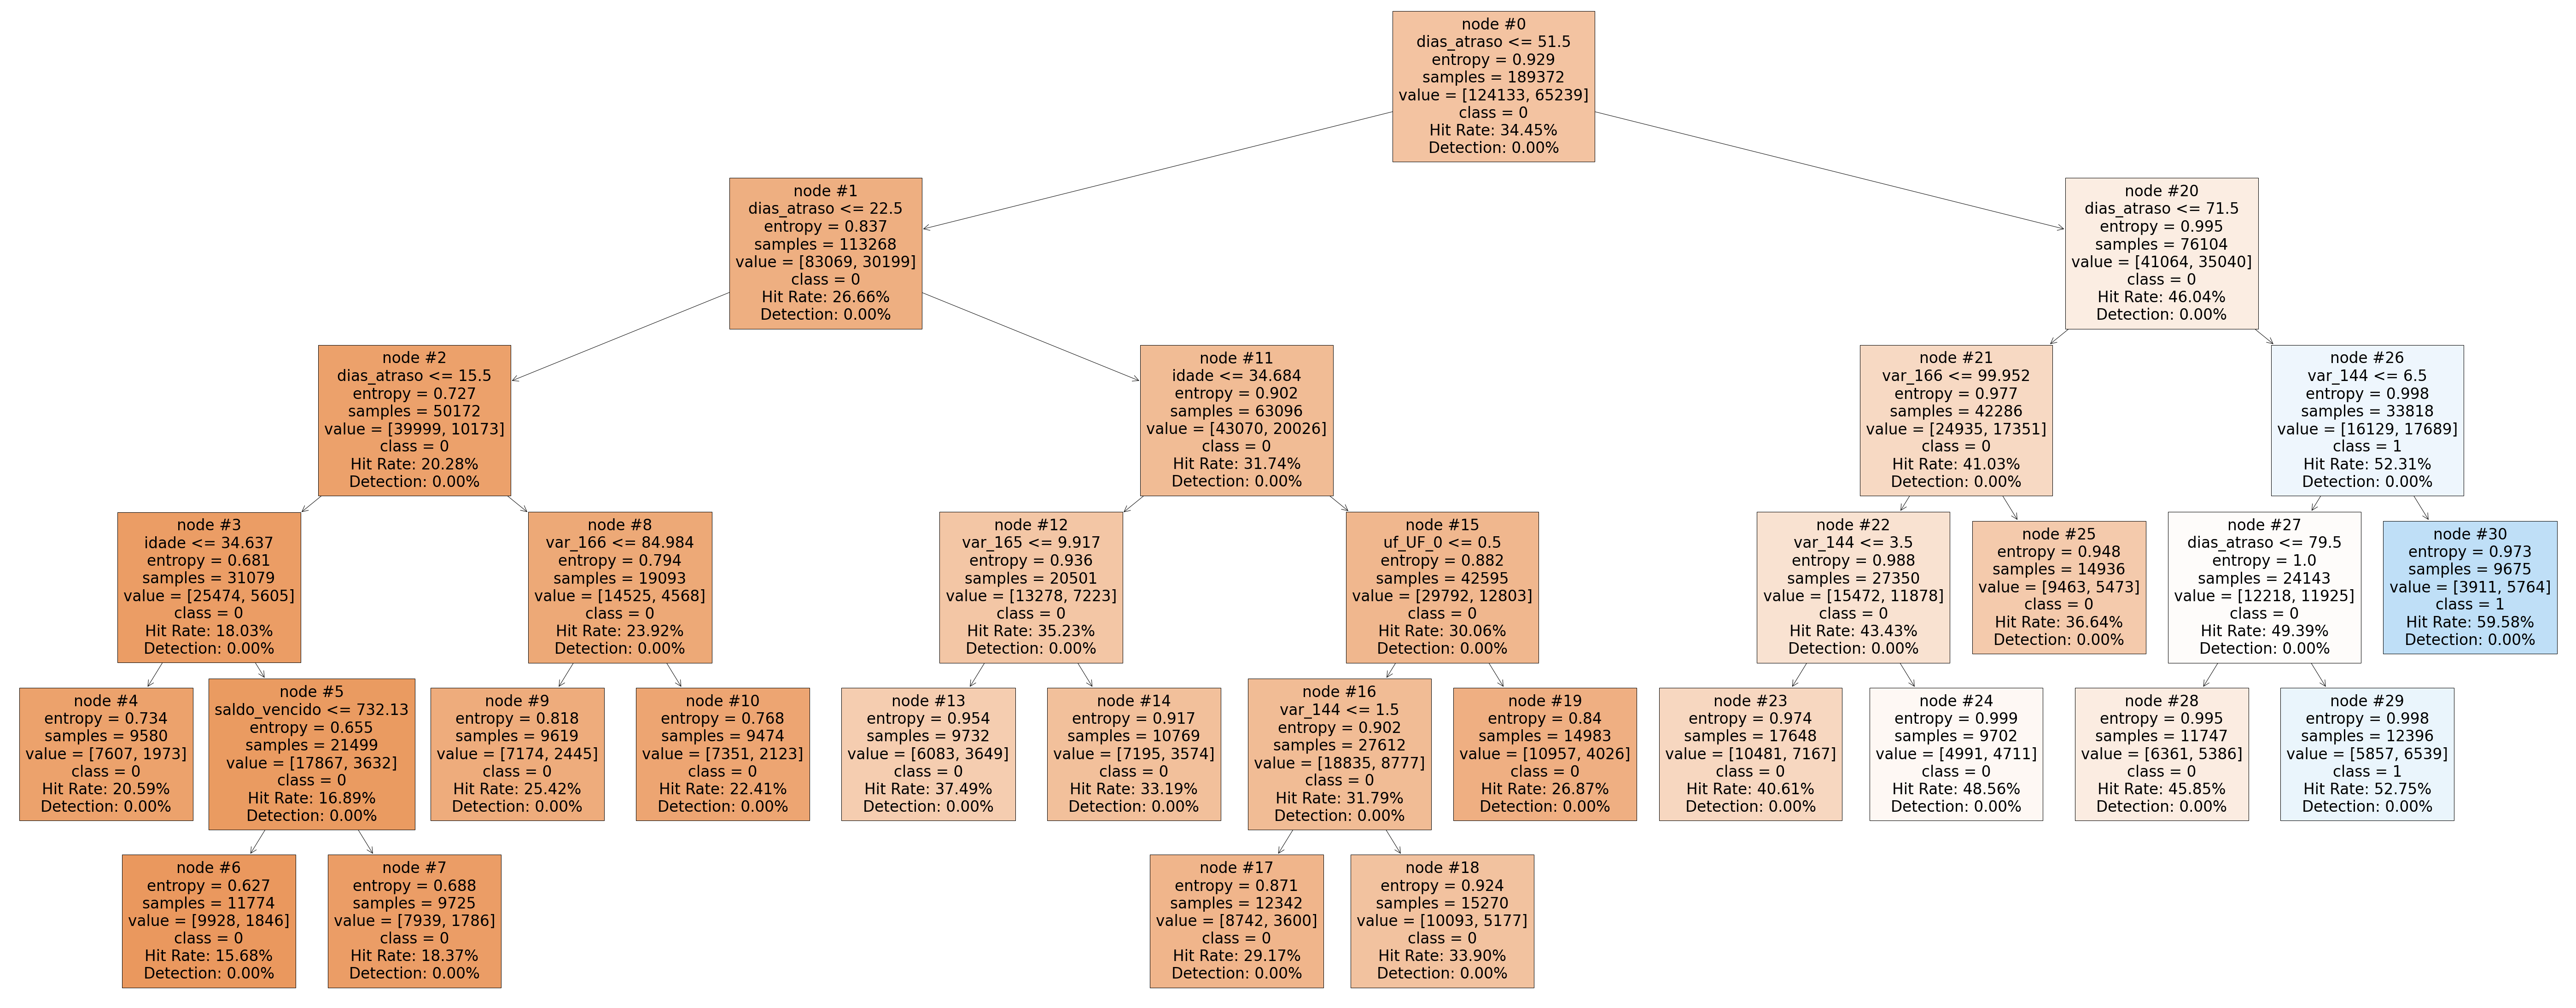

In [136]:
# Visualização da Decision Tree

%matplotlib inline

target_valores = ['0', '1']

def calculate_class_ratios(tree, classes):
    class_ratios = []
    class_detection = []
    total_samples = tree.n_node_samples[0]*tree.value[0][0]
    for i in range(tree.node_count):
        counts = tree.value[i][0]
        total = counts.sum()
        ratios = counts / total
        node_samples = ratios*tree.n_node_samples[i]
        detection = np.divide(node_samples, total_samples)
        class_ratios.append({classes[j]: ratios[j] for j in range(len(classes))})
        class_detection.append({classes[j]: detection[j] for j in range(len(classes))})

    return class_ratios, class_detection

class_ratios, class_detection = calculate_class_ratios(models['Decision Tree'].tree_, target_valores)
plt.figure(figsize=(100, 40))
plot_tree(models['Decision Tree'], class_names=target_valores, filled=True, node_ids=True, feature_names=x_train_final.columns)

ax = plt.gca()
j = 0
for i, txt in enumerate(ax.texts):
    ratios = class_ratios[i - j]
    detection = class_detection[i - j]
    label = txt.get_text()+"\n"+f"Hit Rate: {ratios['1']:.2%}"+"\n"+f"Detection: {detection['1']:.2%}"
    txt.set_text(label)

In [138]:
# Extração das informações dos nós finais das árvores aplicadas às base de treino e teste

nodes_info = []

def get_node_rules(tree, feature_names, node_id=0, current_rule=""):
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]
    
    # Verifica se é um nó final
    if left_child == -1 and right_child == -1:  # -1 indica que o nó é uma folha (nó final)
        rule = current_rule.strip("& ")
        total_cases = tree.n_node_samples[node_id]
        percentage_cases = total_cases / float(tree.n_node_samples[0])
        percentage_maus = tree.value[node_id][0][1] / total_cases

        nodes_info.append({
            "node": node_id,
            "rule": rule,
            "total_percentage": percentage_cases,
            "bad_rate": percentage_maus
        })
    else:
        # Se não for um nó final, continua construindo a regra
        feature = feature_names[tree.feature[node_id]]
        threshold = tree.threshold[node_id]
        
        get_node_rules(tree, feature_names, left_child, f"{current_rule}{feature} <= {threshold:.4f} & ")
        get_node_rules(tree, feature_names, right_child, f"{current_rule}{feature} > {threshold:.4f} & ")

get_node_rules(models['Decision Tree'].tree_, x_train_final.columns)

df_nodes = pd.DataFrame(nodes_info)

def simplify_rule(rule):
    conditions = rule.split(" & ")
    simplified_conditions = {}
    
    for cond in conditions:
        match = re.match(r"([a-zA-Z_][a-zA-Z0-9_]*) (<=|>=|<|>) ([0-9\.]+)", cond)
        if match:
            var, operator, value = match.groups()
            value = float(value)
            
            if var not in simplified_conditions:
                simplified_conditions[var] = {'>': None, '<=': None}
            
            if operator == '<=':
                if simplified_conditions[var]['<='] is None or value < simplified_conditions[var]['<=']:
                    simplified_conditions[var]['<='] = value
            elif operator == '>':
                if simplified_conditions[var]['>'] is None or value > simplified_conditions[var]['>']:
                    simplified_conditions[var]['>'] = value

    # Reconstrua a regra com as condições simplificadas
    new_conditions = []
    for var, limits in simplified_conditions.items():
        if limits['>'] is not None:
            new_conditions.append(f"{var} > {limits['>']}")
        if limits['<='] is not None:
            new_conditions.append(f"{var} <= {limits['<=']}")
    
    return " & ".join(new_conditions)

# Aplicando a função para simplificar as regras
df_nodes['simplified_rule'] = df_nodes['rule'].apply(simplify_rule)
df_nodes = df_nodes[['node', 'simplified_rule', 'total_percentage', 'bad_rate']]
node_indicator_test = models['Decision Tree'].apply(x_test_final)

df_test_with_nodes = x_test_final.copy()
df_test_with_nodes['node'] = node_indicator_test
df_test_with_nodes['target'] = y_test 

df_nodes_test = df_test_with_nodes.groupby('node').agg(
    num_cases=('target', 'size'),
    num_bads=('target', 'sum')
).reset_index()

df_nodes_test['total_percentage'] = df_nodes_test['num_cases'] / df_test_with_nodes.shape[0]
df_nodes_test['bad_rate'] = df_nodes_test['num_bads'] / df_nodes_test['num_cases']

df_nodes_test = df_nodes_test.merge(df_nodes[['node', 'simplified_rule']], on='node', how='left')

df_nodes_test = df_nodes_test[['node', 'simplified_rule', 'total_percentage', 'bad_rate']]

In [139]:
df_nodes

,node,simplified_rule,total_percentage,bad_rate
0,4,dias_atraso <= 15.5 & idade <= 34.637,0.050588,0.205950
1,6,dias_atraso <= 15.5 & idade > 34.637 & saldo_vencido <= 732.13,0.062174,0.156786
2,7,dias_atraso <= 15.5 & idade > 34.637 & saldo_vencido > 732.13,0.051354,0.183650
3,9,dias_atraso > 15.5 & dias_atraso <= 22.5 & var_166 <= 84.9839,0.050794,0.254184
4,10,dias_atraso > 15.5 & dias_atraso <= 22.5 & var_166 > 84.9839,0.050029,0.224087
5,13,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade <= 34.6835 & var_165 <= 9.9173,0.051391,0.374949
6,14,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade <= 34.6835 & var_165 > 9.9173,0.056867,0.331879
7,17,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade > 34.6835 & uf_UF_0 <= 0.5 & var_144 <= 1.5,0.065173,0.291687
8,18,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade > 34.6835 & uf_UF_0 <= 0.5 & var_144 > 1.5,0.080635,0.339031
9,19,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade > 34.6835 & uf_UF_0 > 0.5,0.079119,0.268705


In [140]:
df_results = df_nodes.sort_values('bad_rate', ascending=False).copy()
df_results.rename(columns={'total_percentage': 'total_percentage_train', 'bad_rate': 'bad_rate_train'}, inplace=True)
df_results = df_results.merge(df_nodes_test[['node', 'total_percentage', 'bad_rate']], on='node', how='left')
df_results.rename(columns={'total_percentage': 'total_percentage_test', 'bad_rate': 'bad_rate_test'}, inplace=True)

df_results

,node,simplified_rule,total_percentage_train,bad_rate_train,total_percentage_test,bad_rate_test
0,30,dias_atraso > 71.5 & var_144 > 6.5,0.051090,0.595762,0.038435,0.503763
1,29,dias_atraso > 79.5 & var_144 <= 6.5,0.065458,0.527509,0.082457,0.509537
2,24,dias_atraso > 51.5 & dias_atraso <= 71.5 & var_166 <= 99.9516 & var_144 > 3.5,0.051232,0.485570,0.031845,0.452171
3,28,dias_atraso > 71.5 & dias_atraso <= 79.5 & var_144 <= 6.5,0.062031,0.458500,0.075162,0.503307
4,23,dias_atraso > 51.5 & dias_atraso <= 71.5 & var_166 <= 99.9516 & var_144 <= 3.5,0.093192,0.406108,0.123296,0.456378
5,13,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade <= 34.6835 & var_165 <= 9.9173,0.051391,0.374949,0.010404,0.348393
6,25,dias_atraso > 51.5 & dias_atraso <= 71.5 & var_166 > 99.9516,0.078871,0.366430,0.064260,0.458714
7,18,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade > 34.6835 & uf_UF_0 <= 0.5 & var_144 > 1.5,0.080635,0.339031,0.056939,0.331799
8,14,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade <= 34.6835 & var_165 > 9.9173,0.056867,0.331879,0.153198,0.346590
9,17,dias_atraso > 22.5 & dias_atraso <= 51.5 & idade > 34.6835 & uf_UF_0 <= 0.5 & var_144 <= 1.5,0.065173,0.291687,0.053603,0.343339


## Resultados

Os piores nós da árvore estão associados a dias de atraso mais altos (acima de 51 dias), e com as variáveis var_144 (maior que 3) e var_166 (menor que 99,95), que não temos informações sobre. <br>
Já os melhores nós da árvore estão associados a dias de atraso mais baixos (até 15 dias) e idade acima de 34 anos. <br>

Separando os nós em 8 grupos homogêneos: <br>

Os 8 grupos possuem ordenação de taxa de maus tanto no treino quanto no teste, variando de 50,7% (pior grupo do teste) a 21,4% (melhor grupo do teste). <br>
Há uma variação de volumetria de casos entre os grupos do treino para o teste não desprezível, de forma que é importante se aprofundar em estudos de estabilidade ao longo das safras.

In [141]:
bins = [0, 0.2, 0.25, 0.3, 0.35,0.4, 0.45, 0.5, 1.0]
labels = ['GH1', 'GH2', 'GH3', 'GH4', 'GH5', 'GH6', 'GH7', 'GH8']

df_results['grouped_node'] = pd.cut(df_results['bad_rate_train'], bins=bins, labels=labels)

df_results_grouped = df_results.groupby('grouped_node', observed=False).agg({
    'total_percentage_train': 'sum',
    'bad_rate_train': lambda x: (x * df_results.loc[x.index, 'total_percentage_train']).sum() / df_results.loc[x.index, 'total_percentage_train'].sum(),
    'total_percentage_test': 'sum',
    'bad_rate_test': lambda x: (x * df_results.loc[x.index, 'total_percentage_test']).sum() / df_results.loc[x.index, 'total_percentage_test'].sum(),
    }).reset_index().sort_values('bad_rate_train', ascending=False)

df_results_grouped

,grouped_node,total_percentage_train,bad_rate_train,total_percentage_test,bad_rate_test
7,GH8,0.116548,0.557428,0.120892,0.507702
6,GH7,0.113264,0.470745,0.107007,0.488089
5,GH6,0.093192,0.406108,0.123296,0.456378
4,GH5,0.130262,0.369791,0.074665,0.443341
3,GH4,0.137502,0.336073,0.210137,0.342582
2,GH3,0.195087,0.272602,0.170029,0.302073
1,GH2,0.100617,0.214968,0.113362,0.223666
0,GH1,0.113528,0.168938,0.080613,0.214398
